<a href="https://colab.research.google.com/github/Girishbl1997/CNN-Trial/blob/main/CNNTrial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Importing the MNIST Dataset


In [461]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.utils import make_grid

import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
%matplotlib inline


In [462]:
# Convert the MNIST Image file into a tensor of 4-Dimensions( # of images, Height, width, color channel)

transform = transforms.ToTensor()

In [463]:
# Training the data

train_data = datasets.MNIST(root='/CNN_data', train = True, download = True, transform = transform )

In [464]:
# Test Data

test_data = datasets.MNIST(root='/CNN_data', train = False, download = True, transform = transform )

In [465]:
train_data

Dataset MNIST
    Number of datapoints: 60000
    Root location: /CNN_data
    Split: Train
    StandardTransform
Transform: ToTensor()

In [466]:
test_data

Dataset MNIST
    Number of datapoints: 10000
    Root location: /CNN_data
    Split: Test
    StandardTransform
Transform: ToTensor()

In [467]:
# Creating a small batch size for training the images
train_loader = DataLoader(train_data, batch_size = 10, shuffle = True)
test_loader = DataLoader(test_data, batch_size = 10, shuffle = False)

In [468]:
# Defining the CNN Model
# Describe Convolutional layer and what it's doing ( Say for instance 2 convolutional layers)

conv1 = nn.Conv2d(1, 6, 3, 1)
conv2 = nn.Conv2d(6, 16, 3, 1)


In [469]:
# Consider 1 image from MNSIT data

for i, (X_Train, y_train) in enumerate(train_data):
  break


In [470]:
X_Train.shape

torch.Size([1, 28, 28])

In [471]:
x = X_Train.view(1,1,28,28)

In [472]:
# Performing the first convolution

x = F.relu(conv1(x)) # Rectified linear unit for our activation function

In [473]:
# 1 single image, 6 is the filetrs we used, 26x26

x.shape

torch.Size([1, 6, 26, 26])

In [474]:
# pass through the pooling layer

x = F.max_pool2d(x,2,2) # kernel of size 2  and stride of 2

In [475]:
x.shape

torch.Size([1, 6, 13, 13])

In [476]:
# The second Convolutional layer

x = F.relu(conv2(x)) # Recitified linear unit for the activation funcition


In [477]:
x.shape # here No padding is set as a result we lose outside of the image (2x2)

torch.Size([1, 16, 11, 11])

In [478]:
# Now the pooling layer

x = F.max_pool2d(x, 2, 2) # kernel of size 2  and stride of 2

In [479]:
x.shape # 5 because you can't invent data to round up as you deleted it.

torch.Size([1, 16, 5, 5])

In [480]:
# Model Class

class ConvolutionalNetwork(nn.Module):
  def __init__(self):
    super().__init__()
    self.conv1 = nn.Conv2d(1,6,3,1)
    self.conv2 = nn.Conv2d(6,16,3,1)

    # Need a Fully connected layer

    self.fc1 = nn.Linear(5*5*16, 120) # 120 just a arbitrary number
    self.fc2 = nn.Linear(120, 84)
    self.fc3 = nn.Linear(84, 10)

  def forward(self, X):
    X = F.relu(self.conv1(X))
    X = F.max_pool2d(X,2,2) # 2x2 kernel and stride of 2

    # Second Pass

    X = F.relu(self.conv2(X))
    X = F.max_pool2d(X,2,2)

    # Re-view to flatten
    X = X.view(-1, 16*5*5) # negative 1, so to verify the batch size

    # fully connected a layers
    X = F.relu(self.fc1(X))
    X = F.relu(self.fc2(X))
    X = self.fc3(X)
    return F.log_softmax(X, dim=1)

In [481]:
# Create an instance of our model
torch.manual_seed(41) # 41 just an arbitrary number
model = ConvolutionalNetwork()
model


ConvolutionalNetwork(
  (conv1): Conv2d(1, 6, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

In [494]:
# Loss function optimizer

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.01) # smaller the number, longer the training rate

# Training and Testing the Model

In [495]:
import time
start_time = time.time()

# Creating Variables to track things
epochs = 5
train_losses = []
test_losses = []
train_correct = []
test_correct = []

# For loop of Epochs
for i in range(epochs):
  trn_corr = 0
  tst_corr = 0


  # Train
  for b,(X_train, y_train) in enumerate(train_loader):
    b+=1 # start the batches at 1
    y_pred = model(X_train) # get predicted values from the training set. Not flattened 2D
    loss = criterion(y_pred, y_train) # compare the predictions to correct answers in y_train and check whats the diff?

    predicted = torch.max(y_pred.data, 1)[1] # Add up the number of correct predictions.
    batch_corr = (predicted == y_train).sum() # how many we got correct from this batch.
    trn_corr += batch_corr # keep track as the training goes.

    # Update our parameters
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()


    # print the results
    if b%600 == 0 :
      print(f'Epoch: {i} Batch: {b} Loss: {loss.item()}')

  train_losses.append(loss)
  train_correct.append(trn_corr)

  # Test
  with torch.no_grad(): # No gradient so we don't update our weights and biases with test data
    for b, (X_test, y_test) in enumerate(test_loader):
      y_val = model(X_test)
      predicted = torch.max(y_val.data, 1)[1] # Adding up the the correct predictions
      tst_corr+= (predicted == y_test).sum() # True = 1, False = 0 and sum away

  loss = criterion(y_val, y_test)
  test_losses.append(loss)
  test_correct.append(tst_corr)


current_time = time.time()
total = current_time-start_time
print(f'Training Took: {total/60} minutes!')

Epoch: 0 Batch: 600 Loss: 0.6251015067100525
Epoch: 0 Batch: 1200 Loss: 0.24883079528808594
Epoch: 0 Batch: 1800 Loss: 0.0770045667886734
Epoch: 0 Batch: 2400 Loss: 0.004344395827502012
Epoch: 0 Batch: 3000 Loss: 0.2763602137565613
Epoch: 0 Batch: 3600 Loss: 0.16338787972927094
Epoch: 0 Batch: 4200 Loss: 0.004948784131556749
Epoch: 0 Batch: 4800 Loss: 0.366939902305603
Epoch: 0 Batch: 5400 Loss: 0.034905172884464264
Epoch: 0 Batch: 6000 Loss: 0.0037279457319527864
Epoch: 1 Batch: 600 Loss: 0.09747623652219772
Epoch: 1 Batch: 1200 Loss: 0.10621853917837143
Epoch: 1 Batch: 1800 Loss: 0.3686566948890686
Epoch: 1 Batch: 2400 Loss: 0.01847846433520317
Epoch: 1 Batch: 3000 Loss: 0.06442224979400635
Epoch: 1 Batch: 3600 Loss: 0.0013044399674981833
Epoch: 1 Batch: 4200 Loss: 0.037621840834617615
Epoch: 1 Batch: 4800 Loss: 0.004340796731412411
Epoch: 1 Batch: 5400 Loss: 0.41054755449295044
Epoch: 1 Batch: 6000 Loss: 0.9998909831047058
Epoch: 2 Batch: 600 Loss: 0.0005032762419432402
Epoch: 2 Bat

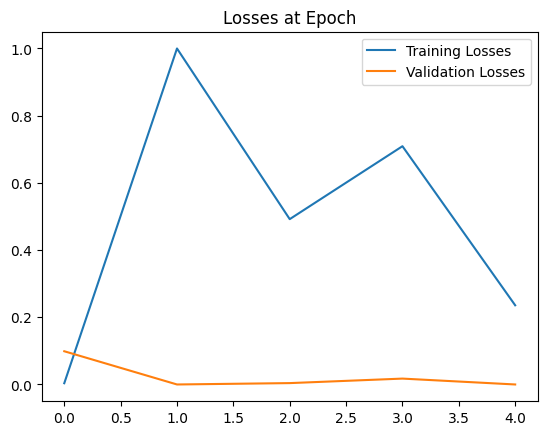

In [496]:
# Graph the loss at epoch

train_losses = [tl.item() for tl in train_losses]
plt.plot(train_losses, label="Training Losses")
plt.plot(test_losses, label= "Validation Losses")
plt.title("Losses at Epoch")
plt.legend()


Text(0.5, 1.0, 'Accuracy at the end of each Epoch')

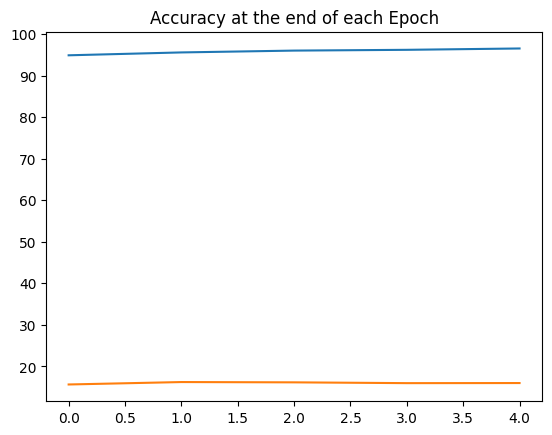

In [501]:
# Graph the accuracy at end of each epoch

plt.plot([t/600 for t in train_correct], label = "Training Accuracy")
plt.plot([t/600 for t in test_correct], label = "Validation Accuracy")
plt.title("Accuracy at the end of each Epoch")

In [502]:
test_load_everything = DataLoader(test_data, batch_size = 10000, shuffle =False)



In [503]:
with torch.no_grad():
  correct = 0
  for X_test, y_test in test_load_everything:
    y_val = model(X_test)
    predicted = torch.max(y_val, 1)[1]
    correct += (predicted == y_test).sum()

In [504]:
# Did for correct
correct.item()

9598

In [505]:
correct.item()/len(test_data)*100

95.98

In [508]:
# Grab an image

test_data[4143] # Tensor with an image in it,It shows the label at the end


(tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 

In [517]:
# Now taking the same data
test_data[1995][0]

tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,

In [518]:
# Reshape the image

test_data[1995][0].reshape(28,28)

tensor([[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000

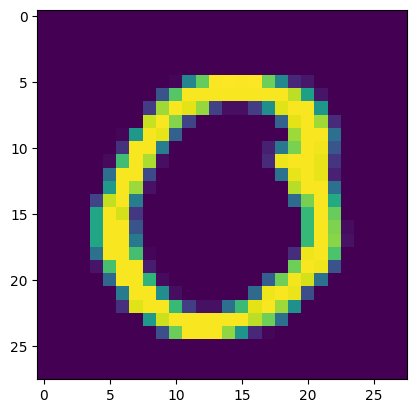

In [523]:
# Show the image
plt.imshow(test_data[1995][0].reshape(28,28))

In [530]:
# pass the image through our model

model.eval()
with torch.no_grad():
  new_prediction = model(test_data[1995][0].view(1,1,28,28)) # batch size of 1, 1 color channel, 28x28 image

In [531]:
# checking the new prediction
new_prediction

tensor([[  0.0000, -82.8025, -38.3914, -65.4033, -52.8001, -36.8312, -25.7993,
         -49.9000, -25.6180, -32.1911]])

In [532]:
new_prediction.argmax()

tensor(0)